## Remap Series 3: Laplacian

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [2]:
import os
import cupy as cp
import numpy as np
import datajoint as dj
import spyglass as nd
import pandas as pd
import matplotlib.pyplot as plt
import json
import multiprocessing

# ignore datajoint+jupyter async warnings
import warnings
warnings.simplefilter('ignore', category=DeprecationWarning)
warnings.simplefilter('ignore', category=ResourceWarning)

from spyglass.common import (Session, IntervalList,LabMember, LabTeam, Raw, Session, Nwbfile,
                            Electrode,LFPBand,interval_list_intersect)
from spyglass.common import TaskEpoch
import spyglass.spikesorting as ss
from spyglass.decoding.clusterless import (UnitMarks,
                                           UnitMarkParameters,UnitMarksIndicatorSelection,
                                          UnitMarksIndicator)
from spyglass.spikesorting import (SortGroup, 
                                    SortInterval,
                                    SpikeSortingPreprocessingParameters,
                                    SpikeSortingRecording, 
                                    SpikeSorterParameters,
                                    SpikeSortingRecordingSelection,
                                    ArtifactDetectionParameters, ArtifactDetectionSelection,
                                    ArtifactRemovedIntervalList, ArtifactDetection,
                                      SpikeSortingSelection, SpikeSorting,
                                   CuratedSpikeSortingSelection,CuratedSpikeSorting,Curation)
from spyglass.spikesorting.curation_figurl import CurationFigurl,CurationFigurlSelection
from spyglass.spikesorting.spikesorting_curation import MetricParameters,MetricSelection,QualityMetrics
from spyglass.spikesorting.spikesorting_curation import WaveformParameters,WaveformSelection,Waveforms
from spyglass.common.common_position import IntervalPositionInfo, IntervalPositionInfoSelection,IntervalLinearizedPosition

from spyglass.utils.nwb_helper_fn import get_nwb_copy_filename
from pprint import pprint
from spyglass.shijiegu.helpers import interval_union

[2023-10-11 15:40:01,928][INFO]: Connecting shijiegu@lmf-db.cin.ucsf.edu:3306
[2023-10-11 15:40:01,962][INFO]: Connected shijiegu@lmf-db.cin.ucsf.edu:3306
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/position_tools/core.py:3: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter1d
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/seaborn/rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


In [3]:
outputFolder='/cumulus/shijie/recording_pilot/eliot/Laplacian/'

In [4]:
def reorder_affinity_by_arm(affinity,arm,linearized_location):
    sort_ind = np.argsort(linearized_location[:-1])
    arm_sortind = np.argsort(arm[sort_ind])
    
    sort_ind = sort_ind[arm_sortind]
    arm_=arm[sort_ind]
    
    N_reorders = np.zeros_like(affinity)
    N_reorders=affinity[sort_ind,:]
    N_reorders=N_reorders[:,sort_ind]
    
    arm_breaks=np.argwhere(np.diff(arm_)).ravel()+1
    arm_breaks=np.concatenate(([0],arm_breaks,[len(linearized_location)-1]))
    
    return N_reorders,arm_breaks

In [5]:
pair=[[0,1],[0,2],[0,3],[1,2],[1,3],[2,3]]  #tetrode channel pairs
color_palet = np.array([[1,0.6,0],[0.7,0.6,0.4],[0.6,0.8,0.3],
                          [0,0.6,.3],[0,0,1],[0,0.6,1],[0,0.7,0.7],
                          [0.7,0,0.7],[0.7,0.4,1]]);
color_palet = color_palet[np.concatenate((np.arange(0,9,2),np.arange(1,9,2)))] # scramble slightly

### Specify date, session, and electrode

In [232]:
nwb_copy_file_name = "eliot20221027_.nwb"

In [233]:
IntervalList_pd=pd.DataFrame(IntervalList & {'nwb_file_name': nwb_copy_file_name})
interval_pd=pd.DataFrame((TaskEpoch & {'nwb_file_name':nwb_copy_file_name}).fetch())
interval_pd.insert(5, "pos_name", '')

# select position timestamps, only maze sessions or sleep are selected
for i in IntervalList_pd.index:
    interval=IntervalList_pd['interval_list_name'][i]
    if interval[0:3]=='pos':
        interval_pd.loc[int(interval[4:6]),'pos_name']=interval

#position_interval=interval_pd.pos_name #use this line if needed
session_interval=[]
position_interval=[]
for i in interval_pd.index:
    if interval_pd.loc[i,"task_name"]=="maze":
        session_interval.append(interval_pd.loc[i,"interval_list_name"])
        position_interval.append(interval_pd.loc[i,"pos_name"])
        
print(session_interval)
print(position_interval)

['02_Seq2Session1', '04_Seq2Session2', '06_Seq2Session3', '08_Seq1Session4', '10_Seq1Session5', '12_Seq1Session6']
['pos 1 valid times', 'pos 3 valid times', 'pos 5 valid times', 'pos 7 valid times', 'pos 9 valid times', 'pos 11 valid times']


## Pick a session

In [234]:
session_ind = 2
session_name = session_interval[session_ind]
pos_name = position_interval[session_ind]
print(session_name)

06_Seq2Session3


### Get Position Info

In [235]:
position_speed = (IntervalPositionInfo & {'nwb_file_name': nwb_copy_file_name,
                  'interval_list_name': pos_name,
                  'position_info_param_name': 'default'}).fetch1_dataframe()

[2023-10-11 22:41:46,883][WARNING]: Skipped checksum for file with hash: 393e030f-3175-936e-23c5-41ac68273e38, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_9I18HQRIQ0.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationW

In [236]:
position_info = (IntervalLinearizedPosition() &
                 {'nwb_file_name': nwb_copy_file_name,
                  'interval_list_name': pos_name,
                  'position_info_param_name': 'default'}
                ).fetch1_dataframe()
position_info

[2023-10-11 22:41:47,460][WARNING]: Skipped checksum for file with hash: fa2a7c9f-1ae6-ac58-821d-1c8aaa8ede8c, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_SNCQOR3RHE.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationW

,linear_position,track_segment_id,projected_x_position,projected_y_position
time,,,,
1.666904e+09,3.413490,0,210.486888,230.594740
1.666904e+09,3.159755,0,210.469279,230.847863
1.666904e+09,3.226442,0,210.473907,230.781337
1.666904e+09,3.604875,0,210.500169,230.403816
1.666904e+09,3.533851,0,210.495240,230.474669
...,...,...,...,...
1.666905e+09,NaN,0,NaN,NaN
1.666905e+09,NaN,0,NaN,NaN
1.666905e+09,NaN,0,NaN,NaN


### For one session: 
##### 1) remove noise units
##### 2) find spike times for nonnoise units
##### 3) construct nn graph
##### 4) embed with Laplacian

In [237]:
key = {"nwb_file_name": nwb_copy_file_name,
       "sorter":"mountainsort4",
       "sort_interval_name":session_name}

In [238]:
sort_group_ids = (QualityMetrics & key).fetch("sort_group_id")
sort_group_ids

array([ 0,  2,  5, 13, 14, 16, 17, 20, 26, 27, 29, 30, 31])

In [239]:
# decide discretization and duration of data
# use beginning
session_start = position_info.index[np.argwhere(np.array(position_info.track_segment_id>0)).ravel()[0]]
session_end = session_start + 25*60 #spikes.loc[1,"sort_interval"][0][-1][-1]
# use last
#session_end = position_info.index[np.argwhere(np.array(position_info.track_segment_id>0)).ravel()[-1]]-2*60
#session_start = session_end - 22*60 #spikes.loc[1,"sort_interval"][0][-1][-1]

delta_t = 0.2 #200 ms
time_axis = np.arange(session_start,session_end,delta_t) #200 ms bins

In [240]:
# Discretize position info
assert position_speed.shape[0] == position_info.shape[0]
arm=np.zeros_like(time_axis).astype('int');
linearized_location = np.zeros_like(time_axis)+np.nan;
speed = np.zeros_like(time_axis)+np.nan;

for t_ind in range(len(time_axis)):
    t = time_axis[t_ind]
    time_ind = np.argwhere(position_info.index>=t).ravel()[0]
    
    arm[t_ind] = int(position_info.iloc[time_ind]['track_segment_id'])
    speed[t_ind] = position_speed.iloc[time_ind]['head_speed']
    armID=position_info.iloc[time_ind]['linear_position']
    
    if not np.isnan(armID):
        linearized_location[t_ind] = int(armID)
arm[arm==1]=5
arm[arm==6]=1
arm[arm==7]=2
arm[arm==8]=3
arm[arm==9]=4

In [241]:
# Discretize neural data
R = []
for tet in sort_group_ids:
    key["sort_group_id"]=tet
    '''
    load metric
    '''
    metrics_json_path=(QualityMetrics & key).fetch1("quality_metrics_path")
    # Opening JSON file
    with open(metrics_json_path) as json_file:
        metrics_json = json.load(json_file)
    snr = metrics_json['snr']

    nwb_units = (CuratedSpikeSorting() & key).fetch_nwb()[0]["units"]

    accepted_units=[unit_id for unit_id in nwb_units.index if snr[str(unit_id)]>=15] #15
    print('Accepted units: ', accepted_units)
    
    cs=(CuratedSpikeSorting() & key).fetch_nwb()
    spikes = pd.DataFrame(cs[0]['units'])
    
    rate_matrix = np.zeros((len(time_axis)-1,len(accepted_units)))
    for i in range(len(accepted_units)):
        u = accepted_units[i]
        hist, _ = np.histogram(spikes.loc[u,'spike_times'],bins=time_axis,density=False)
        rate_matrix[:,i-1]=hist #-1 because index 1 indexed
    rate_matrix = rate_matrix/delta_t
    R.append(rate_matrix)

'''
fig,axes=plt.subplots(1,1,figsize=(15,5))
plt.imshow(rate_matrix.T,aspect='auto',vmax=3)
'''

[2023-10-11 22:41:56,047][WARNING]: Skipped checksum for file with hash: 30b24308-c33f-ed20-2822-6fd8000628bc, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_8P6MH6LXN6.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationW

Accepted units:  [2, 3, 6, 7, 8, 9, 11, 13, 14]


[2023-10-11 22:41:56,563][WARNING]: Skipped checksum for file with hash: 30b24308-c33f-ed20-2822-6fd8000628bc, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_8P6MH6LXN6.nwb
[2023-10-11 22:41:56,995][WARNING]: Skipped checksum for file with hash: 4f48060c-e02e-6361-000f-fcecbb0443af, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_L8S9HE8H9T.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alia

Accepted units:  []


[2023-10-11 22:41:57,498][WARNING]: Skipped checksum for file with hash: 4f48060c-e02e-6361-000f-fcecbb0443af, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_L8S9HE8H9T.nwb
[2023-10-11 22:41:57,933][WARNING]: Skipped checksum for file with hash: 0a1e82c1-94a6-ae1b-0328-fedd91b55994, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_CO1S1YZP2Z.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alia

Accepted units:  [2, 3, 6, 9, 10, 11, 13, 14, 15]


[2023-10-11 22:41:58,462][WARNING]: Skipped checksum for file with hash: 0a1e82c1-94a6-ae1b-0328-fedd91b55994, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_CO1S1YZP2Z.nwb
[2023-10-11 22:41:58,903][WARNING]: Skipped checksum for file with hash: 8232b6d2-067d-b301-96a5-0bab82aee8bd, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_1EFXL33OJT.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alia

Accepted units:  [3, 5, 7, 9, 10, 11]


[2023-10-11 22:41:59,480][WARNING]: Skipped checksum for file with hash: 8232b6d2-067d-b301-96a5-0bab82aee8bd, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_1EFXL33OJT.nwb
[2023-10-11 22:41:59,915][WARNING]: Skipped checksum for file with hash: 6ab41926-7146-6de4-e079-3ee29d9a4b9c, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_MB4USHVD96.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alia

Accepted units:  [4, 7, 9, 10, 18, 19, 20, 21]


[2023-10-11 22:42:00,504][WARNING]: Skipped checksum for file with hash: 6ab41926-7146-6de4-e079-3ee29d9a4b9c, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_MB4USHVD96.nwb
[2023-10-11 22:42:00,956][WARNING]: Skipped checksum for file with hash: 72319583-d21b-3a2e-dba0-11aca398adfe, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_7S87CPWUI6.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alia

Accepted units:  [4, 5, 10, 11, 13]


[2023-10-11 22:42:01,481][WARNING]: Skipped checksum for file with hash: 72319583-d21b-3a2e-dba0-11aca398adfe, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_7S87CPWUI6.nwb
[2023-10-11 22:42:01,960][WARNING]: Skipped checksum for file with hash: eb7fa895-7354-4e33-29ff-eb5e010a0155, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_SYB3URNDNI.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alia

Accepted units:  [5, 6, 7, 11, 12, 13, 14, 16]


[2023-10-11 22:42:02,502][WARNING]: Skipped checksum for file with hash: eb7fa895-7354-4e33-29ff-eb5e010a0155, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_SYB3URNDNI.nwb
[2023-10-11 22:42:02,938][WARNING]: Skipped checksum for file with hash: 49614108-c2b2-3717-5226-99e25a07aa52, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_0AAN6FFYRG.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alia

Accepted units:  [2, 7, 11, 13, 18, 19, 20]


[2023-10-11 22:42:03,556][WARNING]: Skipped checksum for file with hash: 49614108-c2b2-3717-5226-99e25a07aa52, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_0AAN6FFYRG.nwb
[2023-10-11 22:42:04,024][WARNING]: Skipped checksum for file with hash: 80d1659d-d5c3-b313-c963-76a3b47444cf, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_AW45LYZV0E.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alia

Accepted units:  [3, 5, 6, 9, 11]


[2023-10-11 22:42:04,670][WARNING]: Skipped checksum for file with hash: 80d1659d-d5c3-b313-c963-76a3b47444cf, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_AW45LYZV0E.nwb
[2023-10-11 22:42:05,148][WARNING]: Skipped checksum for file with hash: d1f5eb50-de8c-eb34-6a5e-efccf46cd0f0, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_1VYKELVLIS.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alia

Accepted units:  [5]


[2023-10-11 22:42:05,716][WARNING]: Skipped checksum for file with hash: d1f5eb50-de8c-eb34-6a5e-efccf46cd0f0, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_1VYKELVLIS.nwb
[2023-10-11 22:42:06,171][WARNING]: Skipped checksum for file with hash: 0c9eae9d-0b06-5af4-e805-a9dec9d56d6e, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_RJ87G1LQN8.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alia

Accepted units:  [7]


[2023-10-11 22:42:06,777][WARNING]: Skipped checksum for file with hash: 0c9eae9d-0b06-5af4-e805-a9dec9d56d6e, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_RJ87G1LQN8.nwb
[2023-10-11 22:42:07,262][WARNING]: Skipped checksum for file with hash: bab52bfc-9942-d71f-f10c-a30bfcbcecfa, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_VK5QG7BQ1D.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alia

Accepted units:  [6, 7, 8, 11, 12, 13, 15, 17, 19]


[2023-10-11 22:42:07,829][WARNING]: Skipped checksum for file with hash: bab52bfc-9942-d71f-f10c-a30bfcbcecfa, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_VK5QG7BQ1D.nwb
[2023-10-11 22:42:08,290][WARNING]: Skipped checksum for file with hash: 1793d5d1-37ca-2977-03a6-77d0201f861e, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_9TX1AXEHXP.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alia

Accepted units:  [3, 4, 5, 6]


[2023-10-11 22:42:08,941][WARNING]: Skipped checksum for file with hash: 1793d5d1-37ca-2977-03a6-77d0201f861e, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_9TX1AXEHXP.nwb


"\nfig,axes=plt.subplots(1,1,figsize=(15,5))\nplt.imshow(rate_matrix.T,aspect='auto',vmax=3)\n"

In [242]:
R = np.hstack(R);
print(R.shape)

(7499, 72)


In [243]:
arm = arm[:-1]
linearized_location=linearized_location[:-1]
time_axis=time_axis[:-1]
speed=speed[:-1]

In [272]:
arm_only = False
run_only = True

In [273]:
## choose only none center 
if arm_only:
    arm_ind=np.isin(arm,[1,2,3,4])
    R = R[arm_ind,:]
    arm = arm[arm_ind]
    linearized_location=linearized_location[arm_ind]
    time_axis=time_axis[arm_ind]
    
    R=R[:3500,:]
    arm=arm[:3500]
    linearized_location=linearized_location[:3500]
    time_axis=time_axis[:3500]

In [274]:
## choose only none center 
if run_only:
    arm_ind=speed>5
    R = R[arm_ind,:]
    arm = arm[arm_ind]
    linearized_location=linearized_location[arm_ind]
    time_axis=time_axis[arm_ind]
    
    R=R[:4500,:]
    arm=arm[:4500]
    linearized_location=linearized_location[:4500]
    time_axis=time_axis[:4500]

### Spectral Cluster in time direction

In [275]:
'''then use sklearn package'''
from sklearn.manifold import SpectralEmbedding

embedding = SpectralEmbedding(n_components=4,affinity='nearest_neighbors',n_neighbors=50) #n_neighbors=10
X_transformed = embedding.fit_transform(R)
X_transformed.shape

(3671, 4)

In [246]:
N = embedding.affinity_matrix_.toarray()
N_reorders,arm_breaks = reorder_affinity_by_arm(N,arm,linearized_location)

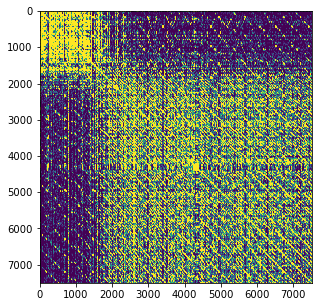

In [247]:
%matplotlib inline
fig,axes=plt.subplots(1,1,figsize=(5,5))
plt.imshow(N,vmax=0.01,interpolation='bilinear', rasterized=False)

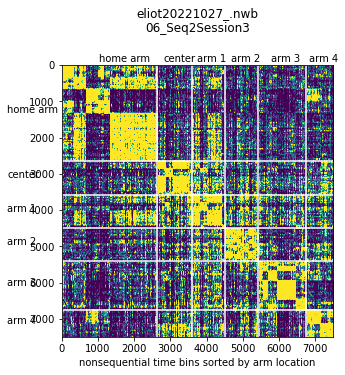

In [248]:
%matplotlib inline
fig,axes=plt.subplots(1,1,figsize=(5,5))
plt.imshow(N_reorders,vmax=0.01,interpolation='bilinear', rasterized=False)
arms_name = ['home arm','center','arm 1','arm 2','arm 3','arm 4']
a_ind=0
for a_ind in range(len(arms_name)):
    b = arm_breaks[a_ind]
    plt.axvline(b,color='w')
    plt.axhline(b,color='w')
    plt.text(-1500,0.5*(b+arm_breaks[a_ind+1]),arms_name[a_ind])
    plt.text(0.5*(b+arm_breaks[a_ind+1])-300,-100,arms_name[a_ind])
axes.set_xlabel('nonsequential time bins sorted by arm location')
figureName=nwb_copy_file_name+'_'+session_name
plt.title(nwb_copy_file_name+'\n'+session_name,y=1.1)
plt.savefig(outputFolder+figureName+'.png', dpi=300,bbox_inches='tight')
plt.savefig(outputFolder+figureName+'.pdf', dpi=300,bbox_inches='tight')

In [276]:
# color code by arms
color_palet[0,:] = [0.5,0.5,0.5]
color_palet[5,:] = [0.6,0.2,0.2]
colors_arm=[]
for t_ind in range(R.shape[0]):
    colors_arm.append(color_palet[arm[t_ind],:])

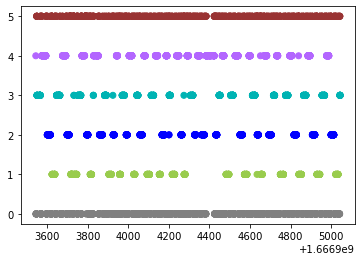

In [277]:
%matplotlib inline
plt.scatter(time_axis,arm,color=colors_arm)

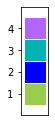

In [199]:
fig,axes=plt.subplots(1,1,figsize=(0.5,2))
for i in range(1,5):
    plt.scatter(1,i,color=color_palet[i,:],s=400,marker='s');
axes.get_xaxis().set_ticks([]);
plt.ylim(0, 5)
axes.get_yaxis().set_ticks([1,2,3,4]);

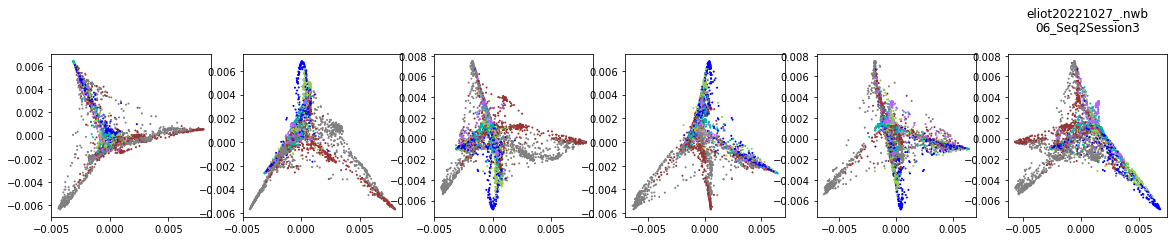

In [278]:
%matplotlib inline

fig,axes=plt.subplots(1,6,figsize=(20,3))

axes[0].scatter(X_transformed[:,0],X_transformed[:,1],color=colors_arm,s=1)
axes[1].scatter(X_transformed[:,0],X_transformed[:,2],color=colors_arm,s=1)
axes[2].scatter(X_transformed[:,0],X_transformed[:,3],color=colors_arm,s=1)
axes[3].scatter(X_transformed[:,1],X_transformed[:,2],color=colors_arm,s=1)
axes[4].scatter(X_transformed[:,1],X_transformed[:,3],color=colors_arm,s=1)
axes[5].scatter(X_transformed[:,2],X_transformed[:,3],color=colors_arm,s=1)

figureName=nwb_copy_file_name+'_'+session_name+'_Laplacian'
plt.title(nwb_copy_file_name+'\n'+session_name,y=1.1)
plt.savefig(outputFolder+figureName+'.png', dpi=300,bbox_inches='tight')
plt.savefig(outputFolder+figureName+'.pdf', dpi=300,bbox_inches='tight')


### Color result by time

In [318]:
import matplotlib.cm as cm
from matplotlib.colors import Normalize

colors=[]
for t_ind in range(len(time_axis)-1):
    colors.append(cm.jet(t_ind/len(time_axis)))

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:477: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:477: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)


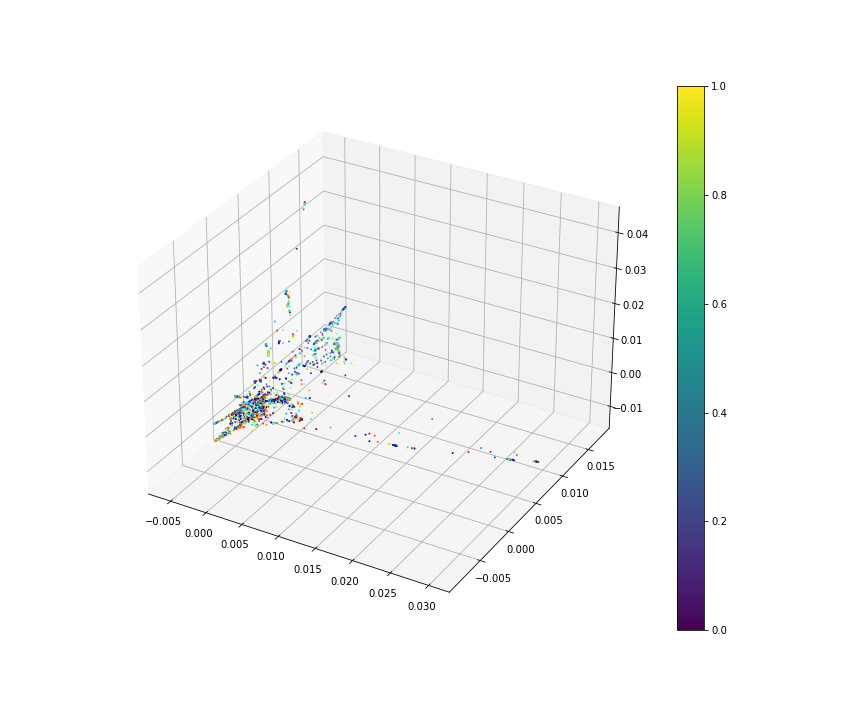

In [319]:
%matplotlib widget
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12,10))
ax=plt.subplot(1,1,1,projection='3d')

plot = ax.scatter(X_transformed[:,0],X_transformed[:,1],X_transformed[:,2],color=colors,s=1)
plt.colorbar(plot)

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:477: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:477: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)


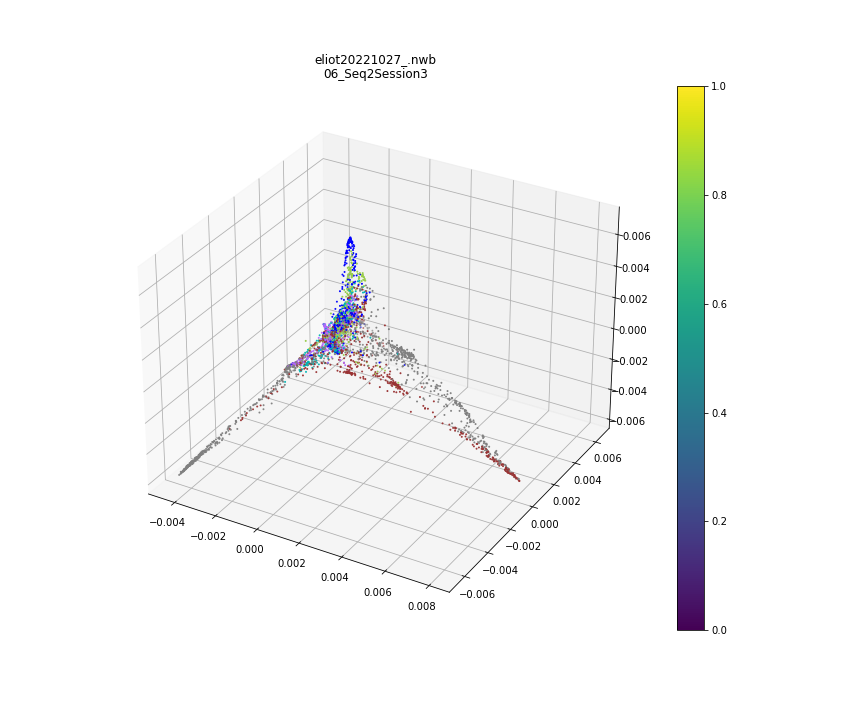

In [279]:
%matplotlib widget
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12,10))
ax=plt.subplot(1,1,1,projection='3d')

plot = ax.scatter(X_transformed[:,0],X_transformed[:,1],X_transformed[:,2],color=colors_arm,s=1)
plt.colorbar(plot)

figureName=nwb_copy_file_name+'_'+session_name+'_Laplacian3D'
plt.title(nwb_copy_file_name+'\n'+session_name,y=1.1)
plt.savefig(outputFolder+figureName+'.png', dpi=300,bbox_inches='tight')
plt.savefig(outputFolder+figureName+'.pdf', dpi=300,bbox_inches='tight')

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:477: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:477: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)


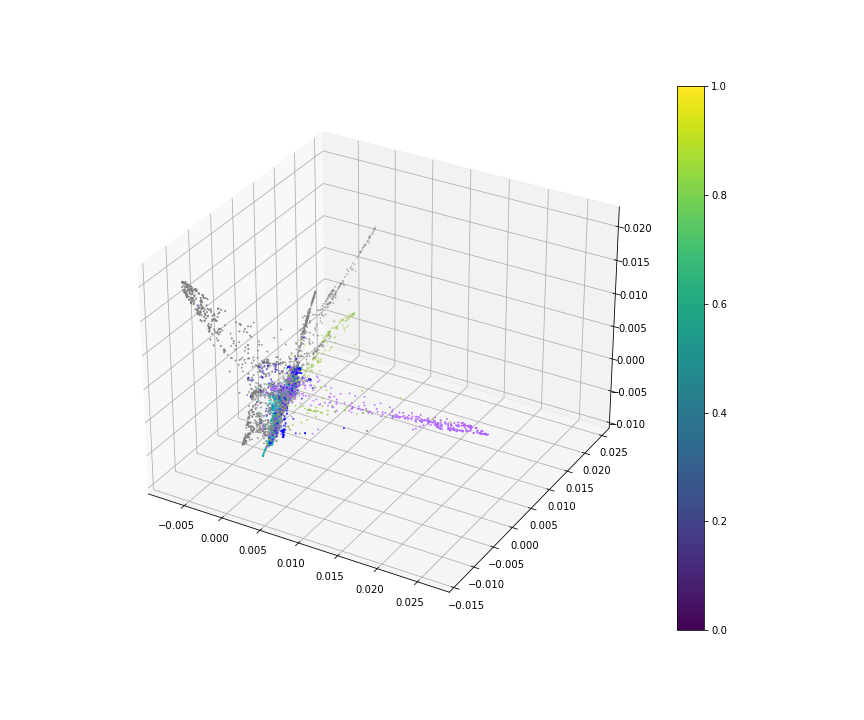

In [596]:
%matplotlib widget
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12,10))
ax=plt.subplot(1,1,1,projection='3d')

plot = ax.scatter(X_transformed[:,1],X_transformed[:,2],X_transformed[:,3],color=colors_arm,s=1)
plt.colorbar(plot)

#### (2) Find cell groups

In [409]:
loading = X_transformed.T @ R

In [410]:
C_embedding = SpectralEmbedding(n_components=3,affinity='nearest_neighbors',n_neighbors=10)
C_transformed = C_embedding.fit_transform(loading.T)
C_transformed.shape

(63, 3)

In [411]:
order = []
cell_group = np.argmax(C_transformed.T,axis=0)
for g in range(C_transformed.shape[1]):
    subordering = np.argsort(-C_transformed[cell_group == g,g])
    order.append(np.argwhere(cell_group == g).ravel()[subordering])
cell_ind=np.hstack(order)
block_boundary=np.argwhere(np.diff(cell_group[cell_ind])).ravel()+1

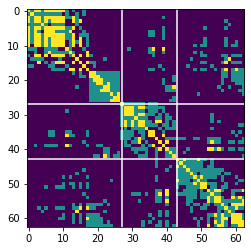

In [412]:
N = C_embedding.affinity_matrix_.toarray() #np.cov(R.T)
plt.imshow(N[cell_ind][:,cell_ind])
for b in block_boundary:
    plt.axvline(b,color='w')
    plt.axhline(b,color='w')

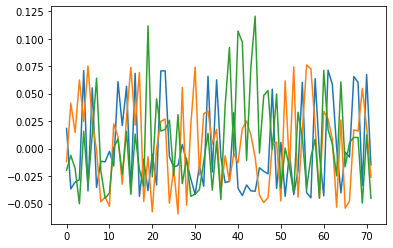

In [152]:
plt.plot(C_transformed)

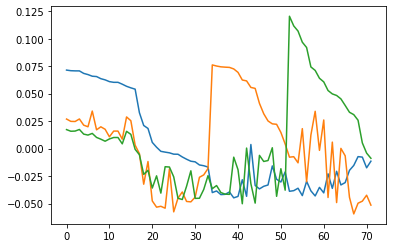

In [153]:
plt.plot(C_transformed[cell_ind,:])

### UMAP

In [280]:
R.shape

(3671, 72)

In [281]:
import umap
reducer = umap.UMAP(n_neighbors=40,min_dist=0.3,n_components=3,metric='cosine') #local_connectivity=15, #40 for early learning
embedding = reducer.fit_transform(R)
embedding.shape

(3671, 3)

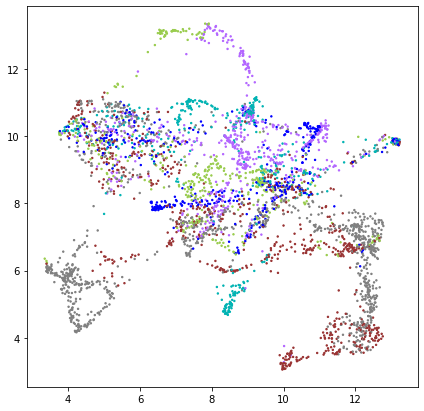

In [282]:
%matplotlib inline

fig,axes=plt.subplots(1,1,figsize=(7,7))

axes.scatter(embedding[:,0],embedding[:,1],color=colors_arm,s=2)

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:477: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:477: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)


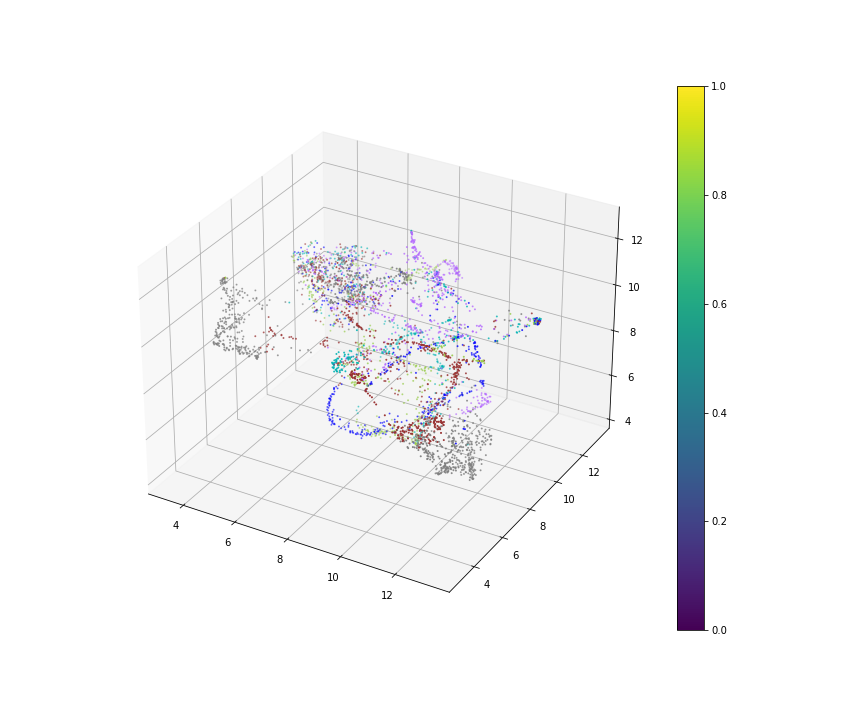

In [283]:
%matplotlib widget
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12,10))
ax=plt.subplot(1,1,1,projection='3d')

plot = ax.scatter(embedding[:,0],embedding[:,1],embedding[:,2],color=colors_arm,s=1)
plt.colorbar(plot)

In [284]:
import umap
reducer = umap.UMAP(n_neighbors=50,min_dist=0.25,metric='cosine',output_metric='haversine',n_components=2) #min_dist=0.2 #local_connectivity=15
embedding = reducer.fit_transform(R)
embedding.shape

(3671, 2)

In [285]:
x = np.sin(embedding[:, 0]) * np.cos(embedding[:, 1])
y = np.sin(embedding[:, 0]) * np.sin(embedding[:, 1])
z = np.cos(embedding[:, 0])

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:477: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:477: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)


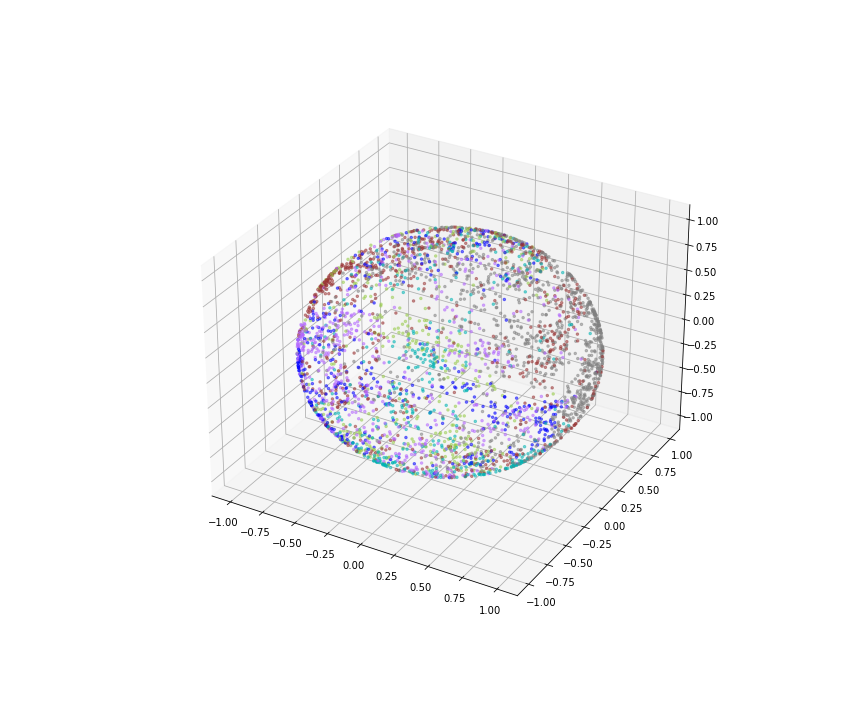

In [286]:
%matplotlib widget
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12,10))
ax=plt.subplot(1,1,1,projection='3d')

ax.scatter(x,y,z,color=colors_arm,s=6,alpha=0.5)

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:477: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:477: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)


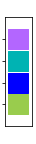

In [603]:
fig,axes=plt.subplots(1,1,figsize=(0.5,2))
for i in range(1,5):
    plt.scatter(1,i,color=color_palet[i,:],s=400,marker='s');
axes.get_xaxis().set_ticks([]);
plt.ylim(0, 5)
axes.get_yaxis().set_ticks([1,2,3,4]);

In [ ]:
%matplotlib widget
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12,10))
ax=plt.subplot(1,1,1,projection='3d')

plot = ax.scatter(X_transformed[:,0],X_transformed[:,1],X_transformed[:,2],color=colors_arm,s=1)
plt.colorbar(plot)

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:477: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:477: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)


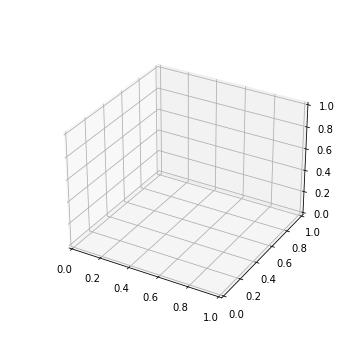

In [50]:
%matplotlib notebook
#widget
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
import time

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(projection='3d')

def animation(i):
    ax.scatter(X_transformed[i,1],X_transformed[i,2],X_transformed[i,3],color='k')
    
ani = FuncAnimation(fig, animation, frames=len(X_transformed[:,1]),interval=20)
plt.show()


## END HERE

### Spectrial Clustering in cell direction

In [440]:
## unused
'''then use sklearn package'''
from sklearn.manifold import SpectralEmbedding

embedding = SpectralEmbedding(n_components=10,affinity='nearest_neighbors',n_neighbors=10)
X_transformed = embedding.fit_transform(R.T)
X_transformed.shape

def pick_high_ind(value):
    # also in the order of descending value
    sort_ind = np.argsort(-value)
    return sort_ind[value[sort_ind]>=np.quantile(value,0.95)]

ind = []
arm_ind=[]
for i in range(10):
    ind.append(pick_high_ind(embedding.embedding_[:,i]))
    arm_ind.append(np.ones(len(pick_high_ind(X_transformed[:,i])))*i)
ind=np.concatenate(ind)
arm_ind=np.concatenate(arm_ind)

_, idx = np.unique(ind, return_index=True)
ind = ind[np.sort(idx)]
arm_ind_ = arm_ind[np.sort(idx)]

arm_breaks=np.argwhere(np.diff(arm_ind_)).ravel()+1
arm_breaks=np.concatenate(([0],arm_breaks))

N=embedding.affinity_matrix_.toarray()
N_=N[ind,:]
N_=N_[:,ind]
%matplotlib inline
fig,axes=plt.subplots(1,1,figsize=(5,5))
plt.imshow(N_)
for b in arm_breaks:
    plt.axvline(b,color='w')
    plt.axhline(b,color='w')

(51, 10)